# Adversarial Attack and Detection in Medical Images using Deap Learning

## Imports
Import common libraries.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Partition data
Partition the data defined in a .csv file, where each row holds the file name of the images and their corresponding label, into three different .csv files; for training, validation and testing. You can specify the ratios of training, validation and test data sets as well as the output directory.

#### Settings

In [2]:
PARTITION = False                             # Set to false once data has been partitioned into .csv files

PARTITION_INPUT_FILE = 'data/data_labels.csv' # File with original images and labels
PARTITION_RATIOS = [0.70, 0.15, 0.15]         # Ratios of training, validation, and test data
PARTITION_UNIFORM = False                     # If to partition data and labels uniformly
PARTITION_OUT_PATH = 'data/2021-11-11/'       # Out path for .csv files for training, validation, and test data

#### Parition data into training, validation, and test data

In [3]:
from data import partition_data

if PARTITION:
    partition_data(input_file=PARTITION_INPUT_FILE,
                   ratios=PARTITION_RATIOS,
                   out_path=PARTITION_OUT_PATH,
                   uniform=PARTITION_UNIFORM)

## Import and transform data
Import the data as training, validation and test data and augment the images if wanted to.

#### Settings

In [4]:
IMAGE_SIZE = 128                           # Image size to resize images to
BATCH_SIZE = 16                            # Batch size to use
NUM_WORKERS = 4                            # Number of workers
IMAGE_ROOT = './data/data_images/'         # Path to images
PARTITION_PATH_ROOT = './data/2021-11-11/' # Path to .csv files with training, validation and test data sets

#### Import and transform data

In [5]:
import albumentations as album
from albumentations.pytorch import ToTensorV2
from data import LoadDatasetFromCSV
from torch.utils.data import DataLoader

# Resize images and rescale values
album_compose = album.Compose([
    album.Resize(IMAGE_SIZE, IMAGE_SIZE),                                          # Resize to IMAGE_SIZE x IMAGE_SIZE
    album.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0], max_pixel_value=255.0), # Rescale values from [0,255] to [0,1]
    album.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5], max_pixel_value=1.0),   # Rescale values from [0,1] to [-1,1]
    ToTensorV2(),
])

# Load training and validation data set
dataset_train = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                   csv_path=PARTITION_PATH_ROOT+'data_labels_train.csv',
                                   transforms=album_compose)
dataset_valid = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                   csv_path=PARTITION_PATH_ROOT+'data_labels_validation.csv',
                                   transforms=album_compose)

# Load data into loaders
dataloader_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

#### Plot some examples from training and validation data sets

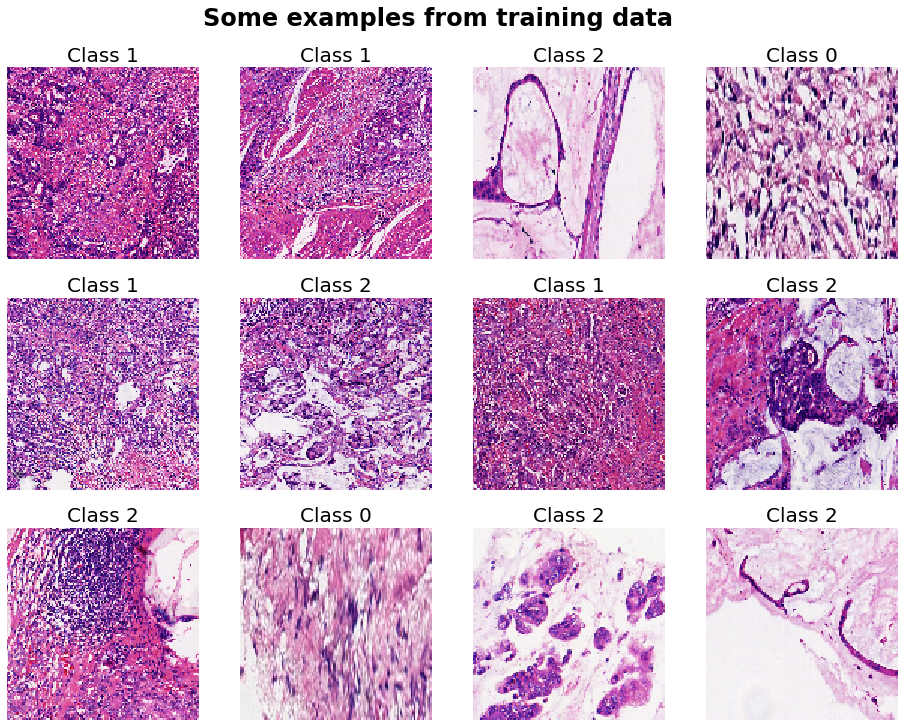

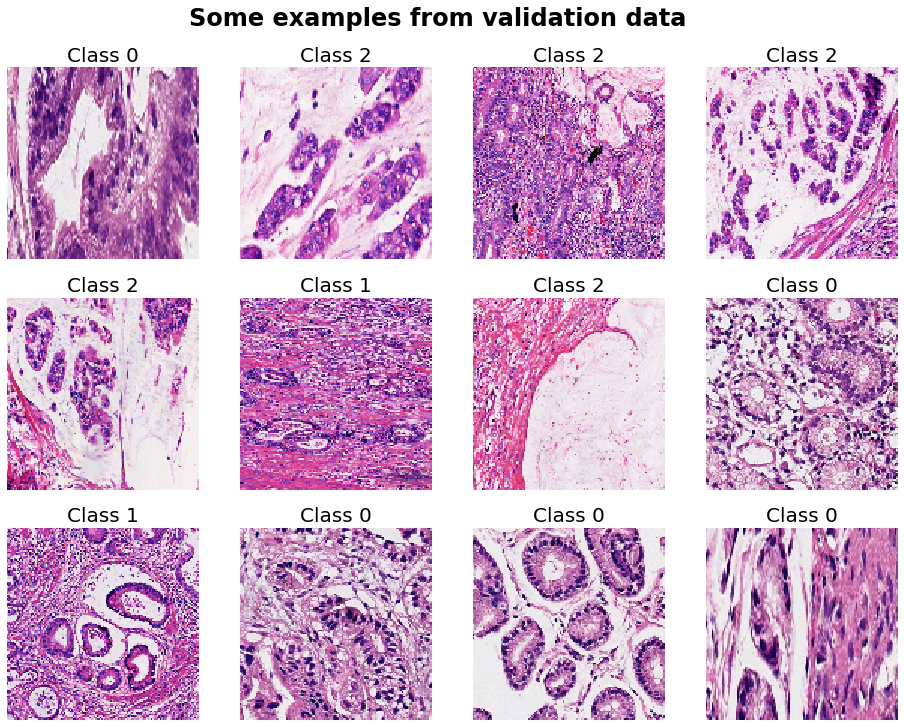

In [6]:
from plot import plot_dataloader

rows, cols, width = 3, 4, 4

# Plot training data
fig, axs = plot_dataloader(dataloader_train, rows=rows, cols=cols, width=width)
fig.suptitle('Some examples from training data', fontsize=24, y=0.95, weight='bold')
plt.show()

# Plot validation data
fig, axs = plot_dataloader(dataloader_valid, rows=rows, cols=cols, width=width)
fig.suptitle('Some examples from validation data', fontsize=24, y=0.95, weight='bold')
plt.show()